In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

import matplotlib.pyplot as plt

import numpy as onp

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as np


# Using an RDF as a scoring function. 

An EDM could come from points in many dimensions, so it's possible that there are multiple weird ways to satisfy any given EDM. These ways would all be consistent with other EDMs, and so the network will be happy, but the actual 3D realisation of those EDMs might _do not_ work how we expect. 

Alternatively, if we directly learn 3D coordinates, and then compare the euclidean distances to a known distribution, then the network is forced to make the distances consistent with what we expect in 3D space. Put another way, the network can't just put all atoms at the same distance as a carbon-carbon bond distance, because there is not enough volume in 3d dimensions to fit all the atoms surrounding the central atom. The surrounding atoms will thus be forced to move outwards, and hopefully it all settles on a reasonable-looking molecule.  

The below fits a loss function using the distributions of known atom distances. 

The network part uses JAX numpy, hence the original numpy is re-nicknamed `onp`.

In [2]:
##load dataset of QM9 isomers. 
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

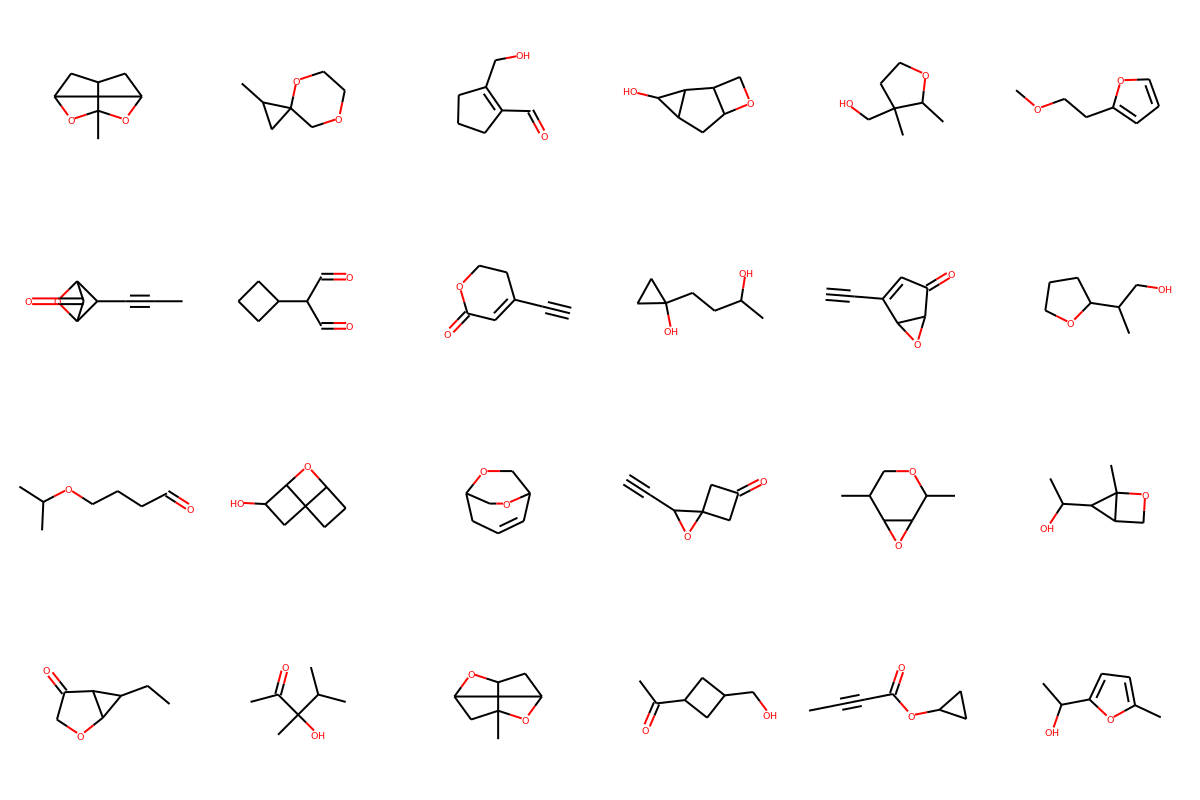

In [3]:
###draw sample
Draw.MolsToGridImage(onp.random.choice(onp.array(mols), 24), molsPerRow=6)


In [5]:
adjacencies = list()
###Run through molecules and make the EDM dataset. 
for count, m in enumerate(onp.random.choice(onp.array(mols), 4000)):
    a = Chem.GetAdjacencyMatrix(m)
    atoms = onp.clip(onp.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
    sort_indices = onp.argsort(onp.array(atoms, dtype=bool))
    #put oxygens at end:
    a = a[sort_indices][:,sort_indices]
    adjacencies.append(squareform(a))

adjacencies = np.array(adjacencies)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
import jax.numpy as np
from jax.config import config
from jax import jit, grad, lax, random, vmap
from jax.ops import index_update, index, index_add


@jit 
def jax_squareform(edm):
    empty = np.zeros([9,9])
    half = index_add(empty, index[np.triu_indices(9,1)], edm)
    full = half+half.T
    return full


In [8]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, lax, random, vmap, value_and_grad
from jax.experimental import optimizers, stax
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu, Dropout, Gelu, Sigmoid
from jax.nn.initializers import he_uniform

In [9]:
##Amazing resource to quickly take distance matrix of any-dimensional data;
##https://github.com/google/jax/issues/787

#normal:
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij


In [109]:
def init_gan(latent_dims=50):
    _, dec_init_rng = random.split(random.PRNGKey(2))
    decoder_init, decode = stax.serial(

        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Sigmoid)

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, latent_dims))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

def init_critic(latent_dims=36):
    _, dec_init_rng = random.split(random.PRNGKey(1))
    decoder_init, decode = stax.serial(

        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(36), Gelu, 
        Dense(1),)

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, latent_dims))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

In [110]:
@jit
def wasserstein_loss(y_true, y_pred):
    return np.mean(y_true * y_pred)

In [111]:

wasserstein_loss(np.array([100,50,150]), np.array([-1,-1,-1]))

DeviceArray(-100., dtype=float32)

In [151]:
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

@jit
def c_wasserstein_loss(params, inputs, labels):
    preds = c_decode(params, inputs)
    return np.mean(preds * labels)

@jit
def g_wasserstein_loss(g_params, c_params, noises, labels):
    #get generated signal
    X_fake = g_decode(g_params, noises)
    #how real/fake does the critic think it is?
    preds = c_wasserstein_loss(c_params, X_fake, -labels)
    
    ##Are the coordinates being one-to-one mapped to the noise:
    instance_distances = E_fn(X_fake)[np.triu_indices(noises.shape[0], 1)]
    noise_distances = E_fn(noises)[np.triu_indices(noises.shape[0], 1)]
    diversity_loss = np.mean((instance_distances/np.max(instance_distances) / noise_distances/np.max(noise_distances)))

    return np.mean(preds * labels) +diversity_loss

In [180]:
key = random.PRNGKey(3)
latent_dims=50
####gan:
g_opt_state, g_opt_update, g_decode, g_get_params = init_gan()

###critic:
c_opt_state, c_opt_update, c_decode, c_get_params = init_critic()


##setup some score labels
batch_size = 12
all_true = np.ones(batch_size).astype('float32')
half_true = np.concatenate([np.ones(int(batch_size/2)), np.zeros(int(batch_size/2))])

get_critic_prediction = jit(lambda params, inputs: c_decode(params, inputs))
##


In [ ]:
c_step = 0
g_step = 0

g_l = list()
c_l = list()

def doplot(g_l, c_l):
    plt.plot(g_l, label='g')
    plt.plot(c_l, label='critic')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')

for _ in tqdm_notebook(range(10000)):
    #train the critic:
    for _ in range(5):
        #train on real samples:
        X_real = adjacencies[onp.random.randint(0, len(adjacencies), 12)].astype('float32')
        c_params = c_get_params(c_opt_state)
        lc, g = value_and_grad(c_wasserstein_loss)(c_params, X_real, -all_true)
        c_opt_state = c_opt_update(c_step, g, c_opt_state)
        c_step+=1
        
        #train on fake samples:
        key, noise_key = random.split(key) 
        noises = random.normal(noise_key, shape=(12, latent_dims))
        g_params = g_get_params(g_opt_state)
        X_fake = g_decode(g_params, noises)

        c_params = c_get_params(c_opt_state)
        lc, g = value_and_grad(c_wasserstein_loss)(c_params, X_fake, all_true)
        c_opt_state = c_opt_update(c_step, g, c_opt_state)
        c_step+=1
        
    #train the generator:
    key, noise_key = random.split(key) 
    noises = random.normal(noise_key, shape=(24, latent_dims))
    
    g_params = g_get_params(g_opt_state)
    lg, g = value_and_grad(g_wasserstein_loss)(g_params, c_params, noises, -all_true)
    g_opt_state = g_opt_update(g_step, g, g_opt_state)
    g_step+=1
    
    if g_step%10==0:
        doplot(g_l, c_l)
    
    
    print(lc, lg, end='\r')
    g_l.append(lg)
    c_l.append(lc)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [154]:
key, noise_key = random.split(key) 
noises = random.normal(noise_key, shape=(24, latent_dims))
g_params = g_get_params(g_opt_state)
X_fake = g_decode(g_params, noises)

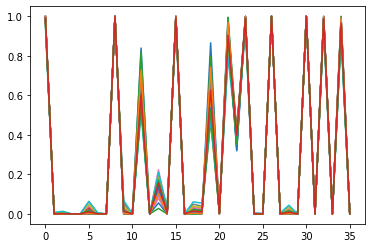

In [155]:
plt.plot(X_fake.T)

In [ ]:
amat = squareform(np.array(gen_imgs[14]>0.1, dtype=int))
import networkx as nx
g = nx.from_numpy_array(amat)
nx.draw(g)

In [ ]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


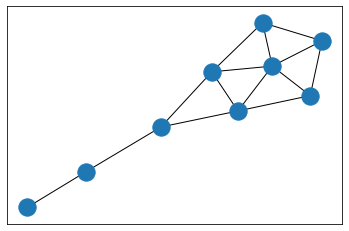

In [1320]:
idx = onp.random.randint(len(many_EDMs))
d = jax_squareform(many_EDMs[idx])
A = squared_exponential(d)-np.eye(9)
lt = np.array(np.less_equal(d, 1.75), dtype='int32')
gt = np.array(np.greater_equal(d, 0.01), dtype='int32')
A = np.bitwise_and(lt, gt)
import networkx as nx
g = nx.from_numpy_array(A)
#nx.draw(g)
edgewidth = [ d['weight'] for (u,v,d) in g.edges(data=True)]
# layout
pos = nx.spring_layout(g, iterations=50)
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos, width=edgewidth*2,)

In [ ]:
atomicNumList = [6]*7+[8]*2

mol = get_proto_mol(atomicNumList)
eMol = Chem.EditableMol(mol)

am = np.array(distance_matrix>0.4).astype(int)-np.eye(9)
bonds = np.triu(am)
for j, k in zip(onp.where(bonds)[0], onp.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None
        
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol